In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np

import sys
sys.path.append("..")

from transformer.model import make_model, EncoderDecoder
from transformer.modules import subsequent_mask, Generator
from time import time
from transformer.datasets import Batch
from typing import Iterator

from matplotlib import pyplot as plt
%matplotlib inline

<h2 align="center">Optimizer</h2>

> We used the Adam optimizer with <i>beta<sub>1</sub> = 0.9</i>, <i>beta<sub>2</sub> = 0.98</i> and <i>epsilon = 10<sup>-9</sup></i>. We varied the learning rate over the course of training, according to the formula:

<h4 align="center"><i>lrate = d_model<sup>-0.5</sup> * min(step_num<sup>-0.5</sup>, step_num * warmup_steps<sup>-1.5</sup>)</i></h4>

> The corresponds to increasing the learning rate linearly for the first *warmup_steps* training steps and decreasing it thereafter proportionally to the incerse square root of the step number. We used *warmup_steps = 4000*.

In [2]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, d_model: int,
                 factor: int, warmup: int,
                 optimizer: torch.optim.Optimizer) -> None:
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.d_model = d_model
        self._rate = 0

    def step(self):
        "Update params and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        learning_rate = (self.d_model ** -0.5) * \
            min(step ** -0.5, step * (self.warmup ** -1.5))
        return self.factor * learning_rate

In [3]:
def get_std_opt(model: EncoderDecoder):
    return NoamOpt(
        model.d_model,
        factor=2,
        warmup=4000,
        optimizer=torch.optim.Adam(
            model.parameters(),
            lr=0, betas=(0.9, 0.98), eps=1e-9
        )
    )

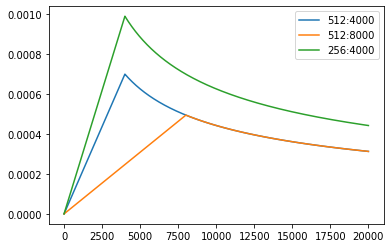

In [4]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"]);

<h2 align="center">Label Smoothing</h2>

During training, we employed label smoothing of value <i>eps<sub>ls</sub> = 0.1</i>. This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.

In [5]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size: int, padding_idx: int, 
                 smoothing: float = 0.0) -> None:
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x: torch.Tensor,
                target: torch.Tensor) -> torch.Tensor:
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, torch.tensor(true_dist, requires_grad=False))

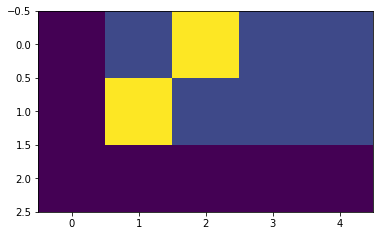

In [6]:
# Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(torch.tensor(predict.log()),
         torch.LongTensor([2, 1, 0]))

plt.imshow(crit.true_dist);

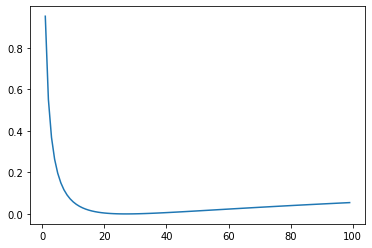

In [7]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    return crit(torch.tensor(predict.log()), torch.LongTensor([1])).item()
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)]);

<h2 align="center">Training Loop</h2>

In [23]:
def run_epoch(data_iter: Iterator[Batch], model: EncoderDecoder, loss_compute: nn.Module):
    "Standard Training and Logging Function"
    start = time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model(
            src=batch.src, tgt=batch.trg, 
            src_mask=batch.src_mask,
            tgt_mask=batch.trg_mask
        )
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens

        if i%50 == 1:
            elapsed = time() - start
            print(
                f"Epoch step: {i} Loss: {loss / batch.ntokens} "
                f"Tokens per sec: {tokens/elapsed}"
            )
            start = time()
            tokens = 0
        
    return total_loss / total_tokens

<h2 align="center">Example</h2>

### Synthetic Data

In [24]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch, 10))
        data[:, 0] = 1
        src = torch.tensor(data, requires_grad=False)
        tgt = torch.tensor(data, requires_grad=False)
        yield Batch(src, tgt, 0, mask_fn=subsequent_mask)

### Loss Computation

In [25]:
class SimpleLossCompute:
    "A simple loss compute and train function"
    def __init__(self, generator: Generator, criterion: nn.Module, opt: NoamOpt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm

In [28]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

Epoch step: 1 Loss: 3.196305751800537 Tokens per sec: 701.865478515625
Epoch step: 1 Loss: 2.391780138015747 Tokens per sec: 1339.5577392578125
tensor(2.3966)
Epoch step: 1 Loss: 2.3749663829803467 Tokens per sec: 900.0033569335938
Epoch step: 1 Loss: 2.3394649028778076 Tokens per sec: 1402.80419921875
tensor(2.3351)
Epoch step: 1 Loss: 2.4208357334136963 Tokens per sec: 898.8564453125
Epoch step: 1 Loss: 2.3201537132263184 Tokens per sec: 1436.3389892578125
tensor(2.3489)
Epoch step: 1 Loss: 2.4099550247192383 Tokens per sec: 858.133544921875
Epoch step: 1 Loss: 2.356799840927124 Tokens per sec: 1331.3387451171875
tensor(2.3437)
Epoch step: 1 Loss: 2.452242136001587 Tokens per sec: 886.007568359375
Epoch step: 1 Loss: 2.3116118907928467 Tokens per sec: 1336.195068359375
tensor(2.3469)
Epoch step: 1 Loss: 2.392141342163086 Tokens per sec: 838.67626953125
Epoch step: 1 Loss: 2.319632053375244 Tokens per sec: 1449.283447265625
tensor(2.3194)
Epoch step: 1 Loss: 2.354390859603882 Tokens p

In [27]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           ys, 
                           subsequent_mask(ys.size(1))
                                    .type_as(src.data))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]])
src_mask = torch.ones(1, 1, 10)
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[1, 6, 6, 6, 6, 6, 6, 6, 6, 6]])
